In [ ]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import time

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import nltk
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D, Activation, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras import callbacks

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [ ]:
def plot_model(history): 
    fig, axs = plt.subplots(1, 2, figsize=(16, 5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Accuracy of epochs')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_val = pd.read_csv('./data/val.csv')

In [ ]:
df_train.head()

,id,text,class
0,0,"@alisachachka не уезжаааааааай. :(❤ я тоже не хочу, чтобы ты уезжала.",0
1,1,"RT @GalyginVadim: Ребята и девчата!\r\nВсе в кино!!! ""Вот Это Любовь!""\r\nСегодня! Завтра! И потом!)))))\r\n#вотэтолюбовь",1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретвит((((( RT,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Запретный плод. :),1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса не боится мороза и .......)),1


In [ ]:
df_test.head()

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не получилось(( ну и хрен с ним"
2,204152,"Хочу лето только ради того, что бы направить ногти ярким лаком :)"
3,204153,"RT @RonyLiss: @colf_ne блин((\r\nа я шипперила ФлораБлум\r\nИ МузаТекна\r\nА Стеллу.. не помню, ахах"
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое воскресенье утром выходит:( а сегодня ..какашка:(просто я иду человека фоткать и мне нужно солн…"


In [ ]:
df_val.head()

,id,text,class
0,181467,RT @TukvaSociopat: Максимальный репост! ))) #євромайдан http://t.co/wxtQ0xGVtp,1
1,181468,"чтоб у меня з.п. ежегодно индексировали на индекс инфляции, как тарифы на автобусы! :(",0
2,181469,@chilyandlime нехуя мне не хорошо !!! :((((,0
3,181470,"@inafish нее , когда ногами ахахах когда?ахаха честн не помню , я тебе завтра в шк покажу как меня прикона пиздят ~((((",0
4,181471,"Хочу сделать как лучше, а получаю как всегда. :(",0


In [ ]:
df_train.tail()

,id,text,class
181462,181462,Классным будет новый год..( http://t.co/LejaGuXNwu,0
181463,181463,Видишь человека хочешь сказать ему привет . А он тебя игнорит :(,0
181464,181464,@Julia6_9Styles там длинный диагноз. Вкратце: аллергический отёк горла с осложнением в виде фолликулярной ангины :(,0
181465,181465,"@technoslav ух ты, а кому тот серенький кнопочне телефон достанется ;)",1
181466,181466,"@Kris1D_07 я тоже так собираюсь сделать:D навешаю фоток вандюх:D \r\nобязательно выложи фотку, как нарядишь:3",1


In [ ]:
df_test.tail()

,id,text
22679,226829,"RT @NickValuev: Небоскребы, небоскребы, а я маленький такой:) http://t.co/ZJ3H12KPPK"
22680,226830,"Первый день в школе в новом году;( 3 человека спросили: все ли у меня в порядке?.. Черный я любою, вот и все"
22681,226831,RT @Killgay_slut: @Your_Novocaine привеееет муда... какой к черту Сэмми? (
22682,226832,"Настроение вроде нормальное, но от чего плакать хочется("
22683,226833,"зашла перед сном к девчонкам)пока они мыли посуду,Настя фоткалась) http://t.co/kiNexuDTuh"


In [ ]:
df_val.tail()

,id,text,class
22678,204145,А я знаю из-за кого такая паршивая погода была сегодня))),1
22679,204146,ааа.... что с Гмейлом. не ужто он умер сегодня :( именно в тот день когда мне надо сдавать журнал в печать,0
22680,204147,"в учебники химии написано ""Пруст Жозеф Луи""\r\nя явно подумала не о том Жозефе и не о том Луи:DD",1
22681,204148,"Вот все любят,а я не люблю..как дура..говорю,что люблю..а сама..(",0
22682,204149,"уххх спасибо дорогой Леле Евгеньевне и Штепуху за сегодняшний все было очень круто ,ну как обычно )))) нас даже научили как готовить бутеры",1


In [ ]:
print(df_train.shape, df_test.shape, df_val.shape)

(181467, 3) (22684, 2) (22683, 3)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181467 entries, 0 to 181466
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      181467 non-null  int64 
 1   text    181467 non-null  object
 2   class   181467 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.2+ MB


In [ ]:
df_train.isnull().sum()

id       0
text     0
class    0
dtype: int64

In [ ]:
df_test.isnull().sum()

id      0
text    0
dtype: int64

In [ ]:
df_val.isnull().sum()

id       0
text     0
class    0
dtype: int64

### Предобработка

In [ ]:
sw = set(get_stop_words('ru'))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [ ]:
def preprocess_reviews(reviews):
    reviews = str(reviews)
    reviews = ''.join(c for c in reviews if c not in exclude)
    reviews = reviews.lower()
    reviews = re.sub("\sне", "не", reviews)
    reviews = [morpher.parse(word)[0].normal_form for word in reviews.split() if word not in sw]
    return " ".join(reviews)

In [ ]:
df_train['text'] = df_train['text'].apply(preprocess_reviews)
df_test['text'] = df_test['text'].apply(preprocess_reviews)
df_val['text'] = df_val['text'].apply(preprocess_reviews)

In [ ]:
df_train.head(3)

,id,text,class
0,0,alisachachkaич уезжаааааааать ❤ тожена хотеть уезжать,0
1,1,rt galyginvadim ребята девчата кино любовь завтра вотэтолюбовь,1
2,2,rt artemklyushin ктоненавидеть пробка ретвит rt,0


In [ ]:
df_test.head(3)

,id,text
0,204150,тектоника рельефсамый ужасный мир мучение
1,204151,ходить запускать шар желание насна получиться хрен они
2,204152,хотеть лето ради направить ноготь яркий лак


In [ ]:
df_val.head(3)

,id,text,class
0,181467,rt tukvasociopat максимальный репост євромайдан httptcowxtq0xgvtp,1
1,181468,зп ежегодно индексировать индекс инфляция тариф автобус,0
2,181469,chilyandlimeнеховать мнен,0


### 0. Baseline

In [ ]:
X_train = df_train['text']
y_train = df_train['class']
X_test = df_val['text']
y_test = df_val['class']

In [ ]:
models = []

models.append(('CountVectorizer_LR', CountVectorizer()))
models.append(('TfidfVectorizer_LR', TfidfVectorizer()))
models.append(('HashingVectorizer_LR', HashingVectorizer()))

In [ ]:
# Logistic Regression
start_time = time.time()
classifier = linear_model.LogisticRegression()

results = []

for name, model in models:
    model.fit(X_train)
    X_train_count = model.transform(X_train)
    X_test_count = model.transform(X_test)
    
    classifier.fit(X_train_count, y_train)
    predictions_train = classifier.predict(X_train_count)
    predictions_test = classifier.predict(X_test_count)
    
    train_accuracy = accuracy_score(y_train, predictions_train)
    test_accuracy = accuracy_score(y_test, predictions_test)

    results.append((name, train_accuracy, test_accuracy))
    
baseline_lr = pd.DataFrame(results, columns = ['model', 'train_accuracy', 'test_accuracy'])
baseline_lr.sort_values('test_accuracy', ascending=False)
lr_time = (time.time() - start_time)

In [ ]:
lr_time

73.10478639602661

In [ ]:
models = []

models.append(('CountVectorizer_LSVC', CountVectorizer()))
models.append(('TfidfVectorizer_LSVC', TfidfVectorizer()))
models.append(('HashingVectorizer_LSVC', HashingVectorizer()))

In [ ]:
# LinearSVC
start_time = time.time()
classifier = LinearSVC()

results = []

for name, model in models:
    model.fit(X_train)
    X_train_count = model.transform(X_train)
    X_test_count = model.transform(X_test)
    
    classifier.fit(X_train_count, y_train)
    predictions_train = classifier.predict(X_train_count)
    predictions_test = classifier.predict(X_test_count)
    
    train_accuracy = accuracy_score(y_train, predictions_train)
    test_accuracy = accuracy_score(y_test, predictions_test)

    results.append((name, train_accuracy, test_accuracy))
    
baseline_lsvc = pd.DataFrame(results, columns = ['model', 'train_accuracy', 'test_accuracy'])
baseline_lsvc.sort_values('test_accuracy', ascending=False)
lsvc_time = (time.time() - start_time)

In [ ]:
lsvc_time

76.34100270271301

### Word Embeddings

In [ ]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [ ]:
# !pip install keras

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1 # Adding 1 because of reserved 0 index
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [ ]:
y_train = df_train['class'].values
y_val = df_val['class'].values

### Simple model

In [ ]:
# Training
epochs = 5
batch_size = 64

In [ ]:
input_dim = X_train.shape[1]  # Number of features

In [ ]:
model_1 = Sequential([
    layers.Dense(10, input_dim=input_dim, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_1.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()
history_1 = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time1 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 4s 1ms/step - loss: 1141.3226 - accuracy: 0.5191 - val_loss: 23.5357 - val_accuracy: 0.5048
Epoch 2/5
2836/2836 [==============================] - 3s 1ms/step - loss: 38.6418 - accuracy: 0.5266 - val_loss: 17.2565 - val_accuracy: 0.5247
Epoch 3/5
2836/2836 [==============================] - 3s 1ms/step - loss: 28.7925 - accuracy: 0.5316 - val_loss: 11.6986 - val_accuracy: 0.5085
Epoch 4/5
2836/2836 [==============================] - 3s 1ms/step - loss: 26.1498 - accuracy: 0.5324 - val_loss: 15.2582 - val_accuracy: 0.5134
Epoch 5/5
2836/2836 [==============================] - 3s 1ms/step - loss: 24.2645 - accuracy: 0.5317 - val_loss: 10.5240 - val_accuracy: 0.5209


In [ ]:
model_time1

18.435710430145264

In [ ]:
score_train1 = model_1.evaluate(X_train, y_train, verbose=0)
score_test1 = model_1.evaluate(X_valid, y_val, verbose=0)

In [ ]:
print('Train loss:', score_train1[0])
print('Train accuracy:', score_train1[1])
print('Test loss:', score_test1[0])
print('Test accuracy:', score_test1[1])

Train loss: 25.365217208862305
Train accuracy: 0.5335901379585266
Test loss: 10.523981094360352
Test accuracy: 0.5209187269210815


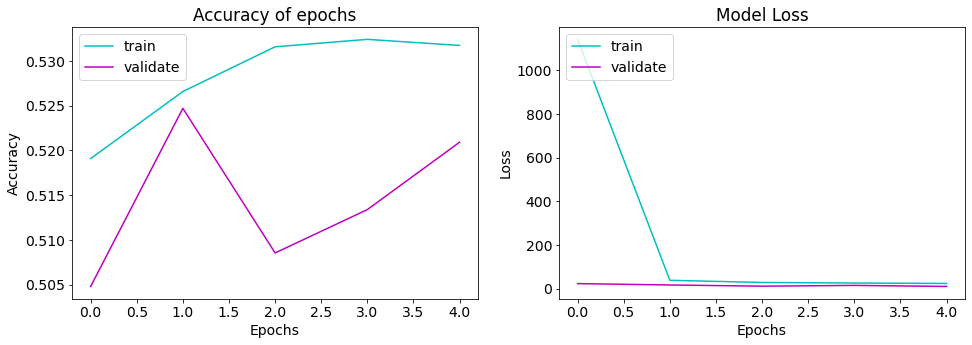

In [ ]:
plot_model(history_1)

In [ ]:
result_1 = pd.DataFrame((score_train1[1], score_test1[1], score_train1[0], score_test1[0])).T
result_1.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_1['model'] = 'Simple model'

### Embedding Layer

In [ ]:
embedding_dim = 50

In [ ]:
model_2 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Flatten(),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_2.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()
history_2 = model_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time2 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 542s 191ms/step - loss: 0.5191 - accuracy: 0.7320 - val_loss: 0.5031 - val_accuracy: 0.7473
Epoch 2/5
2836/2836 [==============================] - 509s 180ms/step - loss: 0.2036 - accuracy: 0.9201 - val_loss: 0.6186 - val_accuracy: 0.7305
Epoch 3/5
2836/2836 [==============================] - 531s 187ms/step - loss: 0.0530 - accuracy: 0.9811 - val_loss: 0.8441 - val_accuracy: 0.7163
Epoch 4/5
2836/2836 [==============================] - 573s 202ms/step - loss: 0.0246 - accuracy: 0.9913 - val_loss: 1.0246 - val_accuracy: 0.7104
Epoch 5/5
2836/2836 [==============================] - 506s 179ms/step - loss: 0.0152 - accuracy: 0.9947 - val_loss: 1.0196 - val_accuracy: 0.7063


In [ ]:
model_time2

2662.739295721054

In [ ]:
score_train2 = model_2.evaluate(X_train, y_train, verbose=0)
score_test2 = model_2.evaluate(X_valid, y_val, verbose=0)

In [ ]:
print('Train loss:', score_train2[0])
print('Train accuracy:', score_train2[1])
print('Test loss:', score_test2[0])
print('Test accuracy:', score_test2[1])

Train loss: 0.008388591930270195
Train accuracy: 0.9978508353233337
Test loss: 1.01956307888031
Test accuracy: 0.706299901008606


In [ ]:
result_2 = pd.DataFrame((score_train2[1], score_test2[1], score_train2[0], score_test2[0])).T
result_2.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_2['model'] = 'Embedding Layer'

### Add GlobalMaxPool1D

In [ ]:
model_3 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.GlobalMaxPool1D(),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_3.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()
history_3 = model_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time3 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 541s 191ms/step - loss: 0.0099 - accuracy: 0.9965 - val_loss: 1.3138 - val_accuracy: 0.7061
Epoch 2/5
2836/2836 [==============================] - 719s 254ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 1.3168 - val_accuracy: 0.7013
Epoch 3/5
2836/2836 [==============================] - 1009s 356ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 1.7325 - val_accuracy: 0.7023
Epoch 4/5
2836/2836 [==============================] - 562s 198ms/step - loss: 0.0034 - accuracy: 0.9988 - val_loss: 1.6327 - val_accuracy: 0.6955
Epoch 5/5
2836/2836 [==============================] - 537s 189ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 1.9597 - val_accuracy: 0.6956


In [ ]:
model_time3

3369.310691356659

In [ ]:
score_train3 = model_3.evaluate(X_train, y_train, verbose=0)
score_test3 = model_3.evaluate(X_valid, y_val, verbose=0)

In [ ]:
print('Train loss:', score_train3[0])
print('Train accuracy:', score_train3[1])
print('Test loss:', score_test3[0])
print('Test accuracy:', score_test3[1])

Train loss: 0.6937695145606995
Train accuracy: 0.4886728823184967
Test loss: 0.6935820579528809
Test accuracy: 0.4912489652633667


In [ ]:
result_3 = pd.DataFrame((score_train3[1], score_test3[1], score_train3[0], score_test3[0])).T
result_3.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_3['model'] = 'Add GlobalMaxPool1D'

### Convolutional Neural Networks (CNN)

In [ ]:
embedding_dim = 100

In [ ]:
model_4 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_4.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()
history_4 = model_4.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time4 = (time.time() - start_time)

In [ ]:
model_time4

In [ ]:
score_train4 = model_4.evaluate(X_train, y_train, verbose=0)
score_test4 = model_4.evaluate(X_valid, y_val, verbose=0)

In [ ]:
print('Train loss:', score_train3[0])
print('Train accuracy:', score_train3[1])
print('Test loss:', score_test3[0])
print('Test accuracy:', score_test3[1])

In [ ]:
plot_model(history_4)

In [ ]:
result_4 = pd.DataFrame((score_train4[1], score_test4[1], score_train4[0], score_test4[0])).T
result_4.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_4['model'] = 'CNN'

### Add Dropout

In [ ]:
model_5 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(10, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_5.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()
history_5 = model_5.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time5 = (time.time() - start_time)

In [ ]:
model_time5

In [ ]:
score_train5 = model_5.evaluate(X_train, y_train, verbose=0)
score_test5 = model_5.evaluate(X_valid, y_val, verbose=0)

In [ ]:
print('Train loss:', score_train3[0])
print('Train accuracy:', score_train3[1])
print('Test loss:', score_test3[0])
print('Test accuracy:', score_test3[1])

In [ ]:
plot_model(history_5)

In [ ]:
result_5 = pd.DataFrame((score_train5[1], score_test5[1], score_train5[0], score_test5[0])).T
result_5.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_5['model'] = 'Add Dropout'

### CNN + LSTM

In [ ]:
model_6 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.LSTM(64),
    layers.Dense(10, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_6.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()
history_6 = model_6.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time6 = (time.time() - start_time)

In [ ]:
model_time6

In [ ]:
score_train6 = model_6.evaluate(X_train, y_train, verbose=0)
score_test6 = model_6.evaluate(X_valid, y_val, verbose=0)

In [ ]:
print('Train loss:', score_train6[0])
print('Train accuracy:', score_train6[1])
print('Test loss:', score_test6[0])
print('Test accuracy:', score_test6[1])

In [ ]:
plot_model(history_6)

In [ ]:
result_6 = pd.DataFrame((score_train6[1], score_test6[1], score_train6[0], score_test6[0])).T
result_6.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_6['model'] = 'CNN + LSTM'

### GRU + CNN

In [ ]:
model_7 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Dropout(0.2),
    layers.Bidirectional(units = 128, return_sequences = TRUE),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(10, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_7.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [ ]:
start_time = time.time()
history_7 = model_7.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time7 = (time.time() - start_time)

In [ ]:
model_time7

In [ ]:
score_train7 = model_7.evaluate(X_train, y_train, verbose=0)
score_test7 = model_7.evaluate(X_valid, y_val, verbose=0)

In [ ]:
print('Train loss:', score_train7[0])
print('Train accuracy:', score_train7[1])
print('Test loss:', score_test7[0])
print('Test accuracy:', score_test7[1])

In [ ]:
plot_model(history_7)

In [ ]:
result_7 = pd.DataFrame((score_train7[1], score_test7[1], score_train7[0], score_test7[0])).T
result_7.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_7['model'] = 'GRU + CNN'

### Results

In [ ]:
final_results = pd.concat([baseline_lr, baseline_lsvc, result_1, result_2, result_3, result_4, result_5, result_6, result_7], axis=0)

In [ ]:
final_results.sort_values('test_accuracy', ascending=False)

In [ ]:
time_results = pd.concat([lr_time, lsvc_time, model_time1, model_time2, model_time3, model_time4, model_time5, model_time6, model_time7], axis=0)

In [ ]:
time_results #.sort_values('test_accuracy', ascending=False)

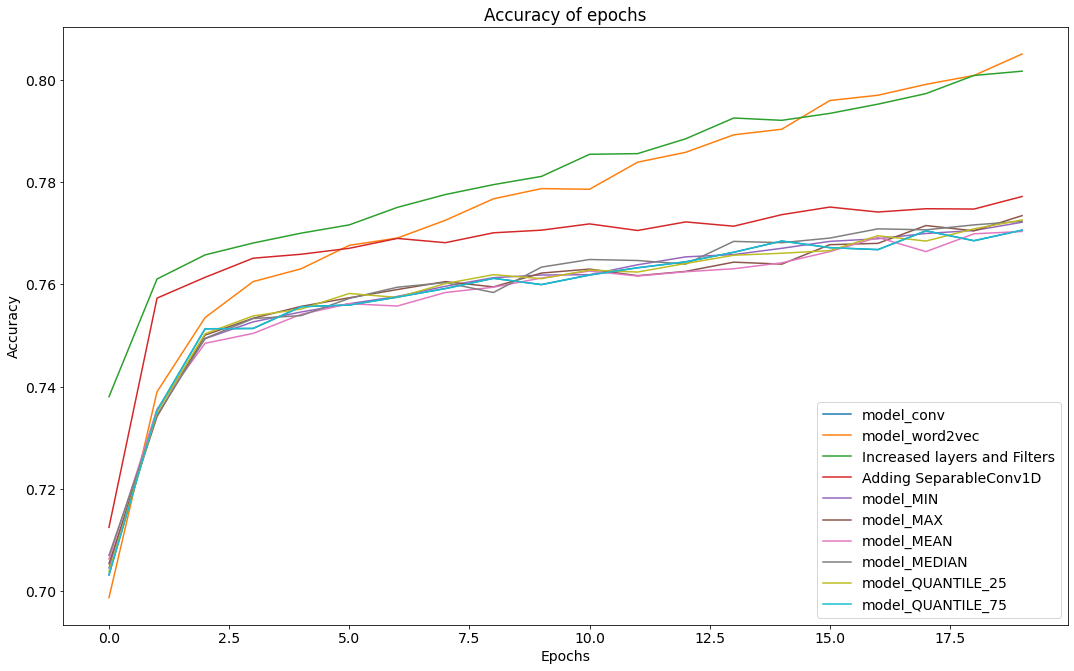

In [ ]:
plt.figure(figsize=(18, 11))
plt.plot(history_1.history['accuracy'], label='Simple model')
plt.plot(history_2.history['accuracy'], label='Embedding Layer')
plt.plot(history_3.history['accuracy'], label='Add GlobalMaxPool1D')
plt.plot(history_4.history['accuracy'], label='CNN')
plt.plot(history_5.history['accuracy'], label='Add Dropout')
plt.plot(history_6.history['accuracy'], label='CNN + LSTM')
plt.plot(history_7.history['accuracy'], label='GRU + CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of epochs')
plt.show()

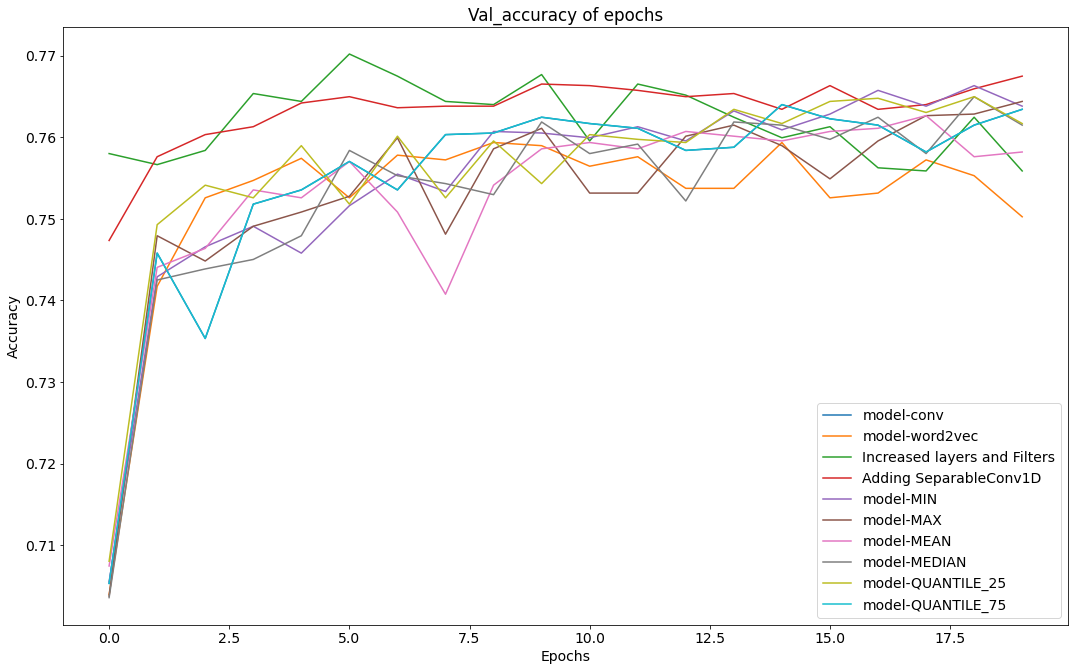

In [ ]:
plt.figure(figsize=(18, 11))
plt.plot(history_1.history['val_accuracy'], label='Simple model')
plt.plot(history_2.history['val_accuracy'], label='Embedding Layer')
plt.plot(history_3.history['val_accuracy'], label='Add GlobalMaxPool1D')
plt.plot(history_4.history['val_accuracy'], label='CNN')
plt.plot(history_5.history['val_accuracy'], label='Add Dropout')
plt.plot(history_6.history['val_accuracy'], label='CNN + LSTM')
plt.plot(history_7.history['val_accuracy'], label='GRU + CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Val_accuracy of epochs')
plt.show()